In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
from graph_format import *
# load local model file and initialize model class
from model import ModelClass
from scipy.optimize import minimize

# Load original model

In [2]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)
%time model.simulate()

CPU times: total: 18min 15s
Wall time: 5min 46s
CPU times: total: 41.3 s
Wall time: 34.4 s


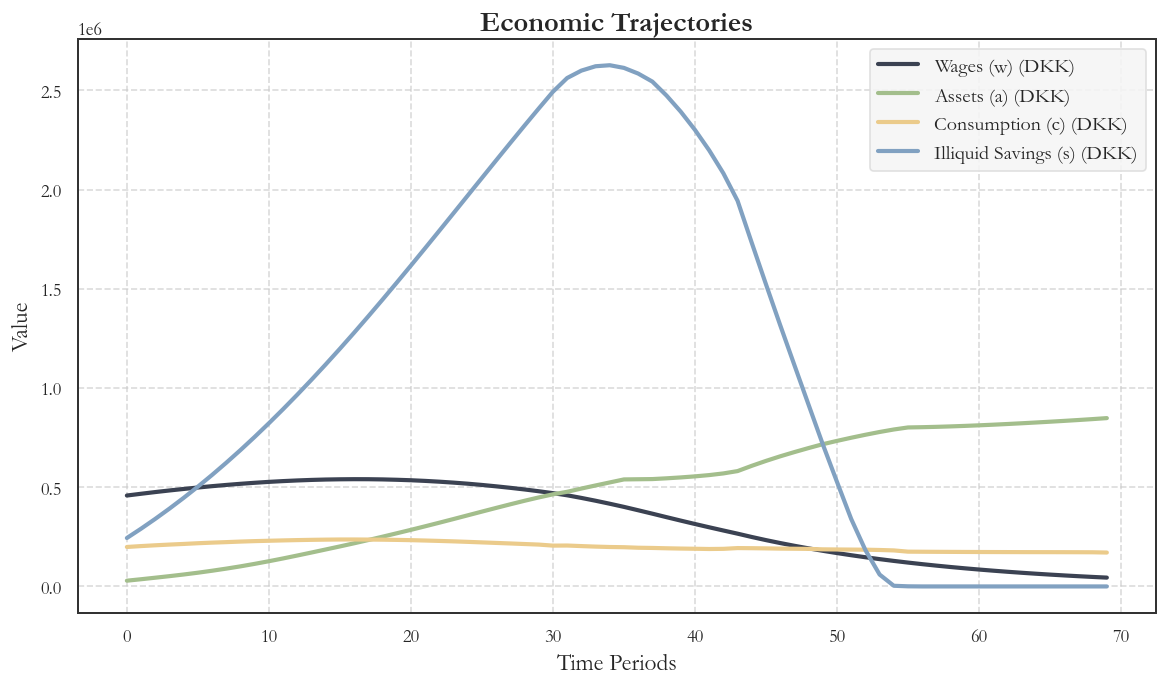

In [3]:
time = np.arange(par.T)
data_dict_basic = {
    "Wages (w)": {"data": np.mean(model.sim.w[:], axis=0), "unit": "DKK"},
    "Assets (a)": {"data": np.mean(model.sim.a[:], axis=0), "unit": "DKK"},
    "Consumption (c)": {"data": np.mean(model.sim.c[:], axis=0), "unit": "DKK"},
    "Illiquid Savings (s)": {"data": np.mean(model.sim.s[:], axis=0), "unit": "DKK"},
}

plot_simulation_one_graph(data_dict_basic, time, title="Economic Trajectories")

# Counter factual

In [4]:
# Change parameters and re-solve
theta = [36]
theta_names = ['retirement_age']

# theta = [0.03]
# theta_names = ['r_a']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)


# Compare models 

Expected welfare  before parameter changes: -31.298332755879997
Expected welfare after parameter changes: -31.29871867705005
Consumption at every age before the policy change must change with -0.0 pct. to keep the same utility, and analytically: -0.0 pct.


c:\Design_retirement\WelfareMeasures.py:83: RuntimeWarning: Mean of empty slice
  sim_og_h = np.nanmean(sim_og_h_ex_1, axis=0)# age specific average
c:\Design_retirement\WelfareMeasures.py:84: RuntimeWarning: Mean of empty slice
  sim_new_h = np.nanmean(sim_new_h_ex_1, axis=0) # age specific average
c:\Design_retirement\WelfareMeasures.py:92: RuntimeWarning: invalid value encountered in divide
  extensive_margin_age = (sim_new_ex-sim_og_ex)/sim_og_ex
c:\Design_retirement\WelfareMeasures.py:99: RuntimeWarning: invalid value encountered in divide
  total_margin_age = (total_margin_new-total_margin_og)/total_margin_og


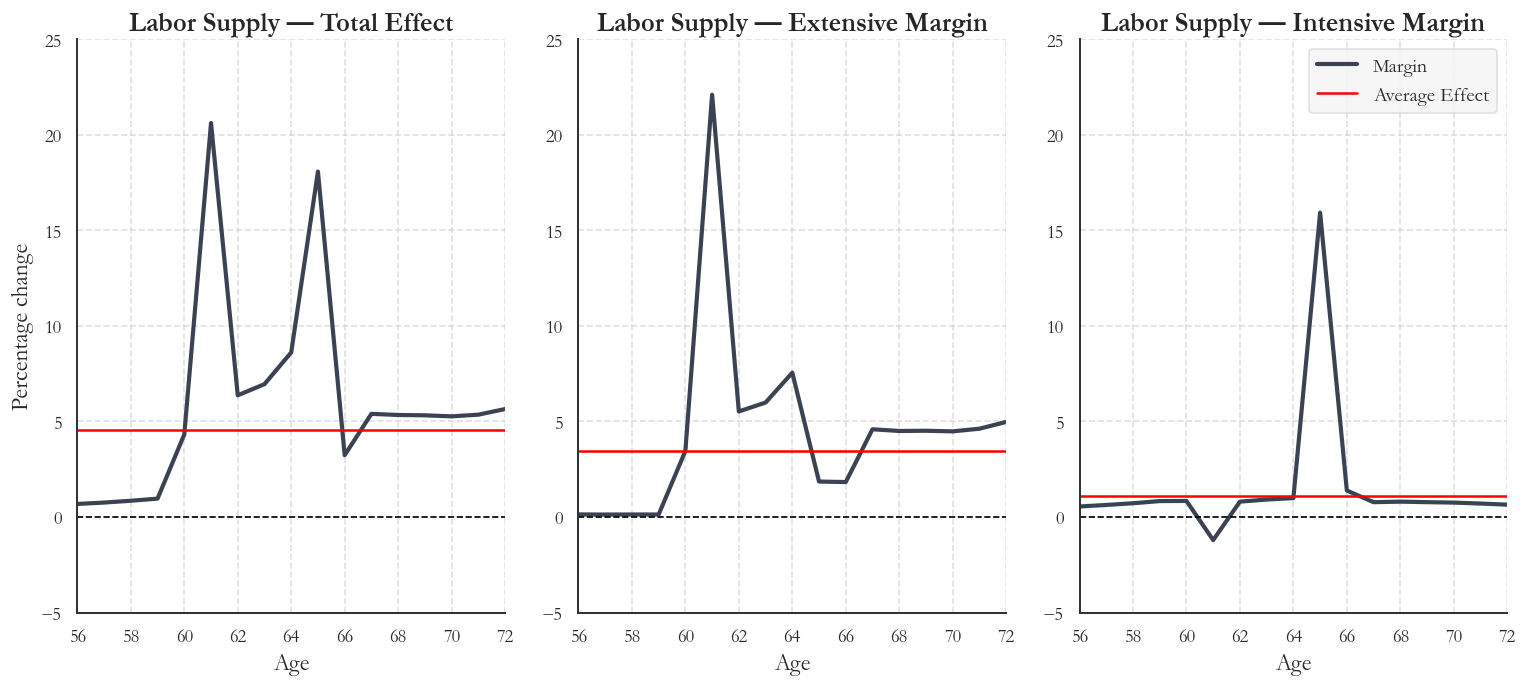

In [5]:
# Compare models 
consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= True, the_method = 'brentq')
intensive_margin, extensive_margin, total_margin, total_per_person, intensive_margin_age, extensive_margin_age, total_margin_age  = labor_elasticity(og_model, new_model)


plot_labor_margins_by_age(
    intensive_age=intensive_margin_age,
    extensive_age=extensive_margin_age,
    total_age=total_margin_age,
    avg_intensive=intensive_margin,
    avg_extensive=extensive_margin,
    avg_total=total_margin,
    age_start=par.start_age,
    title_prefix="Labor Supply — ",
    save_title="counterfactual_labor_margins_by_age.png"
)

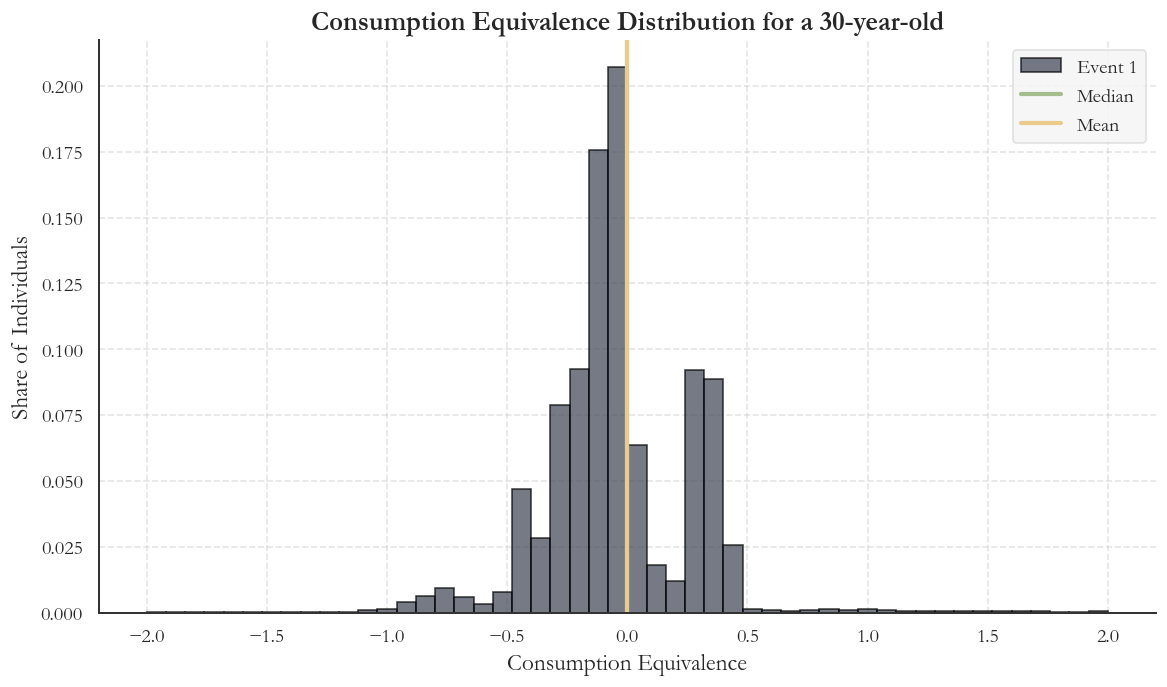

In [6]:
con_eq = analytical_consumption_equivalence_indi(og_model, new_model)
plot_event_histogram(con_eq[:]*100, 'Consumption Equivalence', 'Consumption Equivalence Distribution for a 30-year-old',
                         label1="Event 1",
                         figsize=(10, 6), bins=50, range=(-2,2), median_val=np.median(con_eq), mean_val =np.mean(con_eq), save_title='consumption_equivalence_indi')

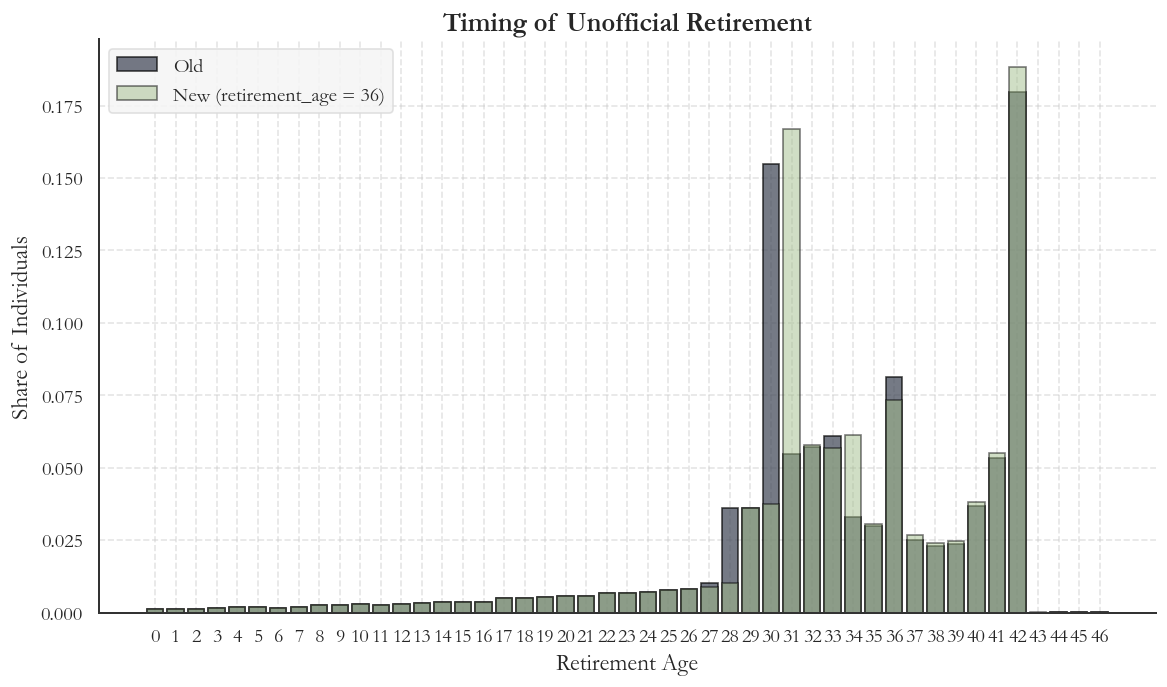

In [7]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(og_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(og_model.sim.ex.shape[0]):
    working = np.where(og_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1]  # last time they worked (take last index)

# 1. Find last time ex == 1 for each individual
last_working_new = np.full(new_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(new_model.sim.ex.shape[0]):
    working_new = np.where(new_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working_new.size > 0:
        last_working_new[i] = working_new[-1]  # last time they worked (take last index)

plot_event_bar_series(
    values1=last_working,
    values2=last_working_new,
    xlabel="Retirement Age",
    title="Timing of Unofficial Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_retirement_age.png",
)


In [8]:
def official_retirement(model):
    first_retirement = np.full(model.sim.e.shape[0], np.nan)  # initialize

    for i in range(model.sim.e.shape[0]):
        retired = np.where(model.sim.e[i, :] == 2)[0]  # find where e=2
        if retired.size > 0:
            first_retirement[i] = retired[0]  # first time they retire
        if model.sim.efter_init[i]:
            if len(model.sim.ex[i,:]) - np.argmax(model.sim.ex[i,:][::-1] == 1)< first_retirement[i]:
                first_retirement[i] = len(model.sim.ex[i,:]) - np.argmax(model.sim.ex[i,:][::-1] == 1)

    return first_retirement

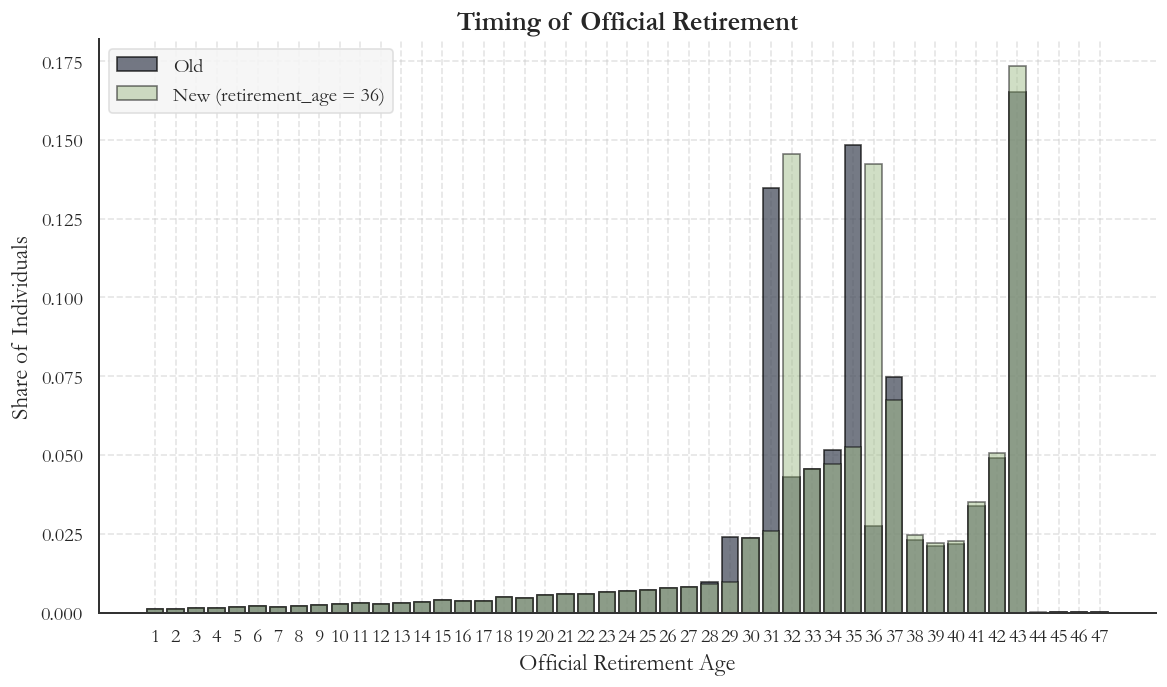

In [9]:
first_retirement_og = official_retirement(og_model)
first_retirement_new = official_retirement(new_model)

plot_event_bar_series(
    values1=first_retirement_og,
    values2=first_retirement_new,
    xlabel="Official Retirement Age",
    title="Timing of Official Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_official_retirement_age.png",
)


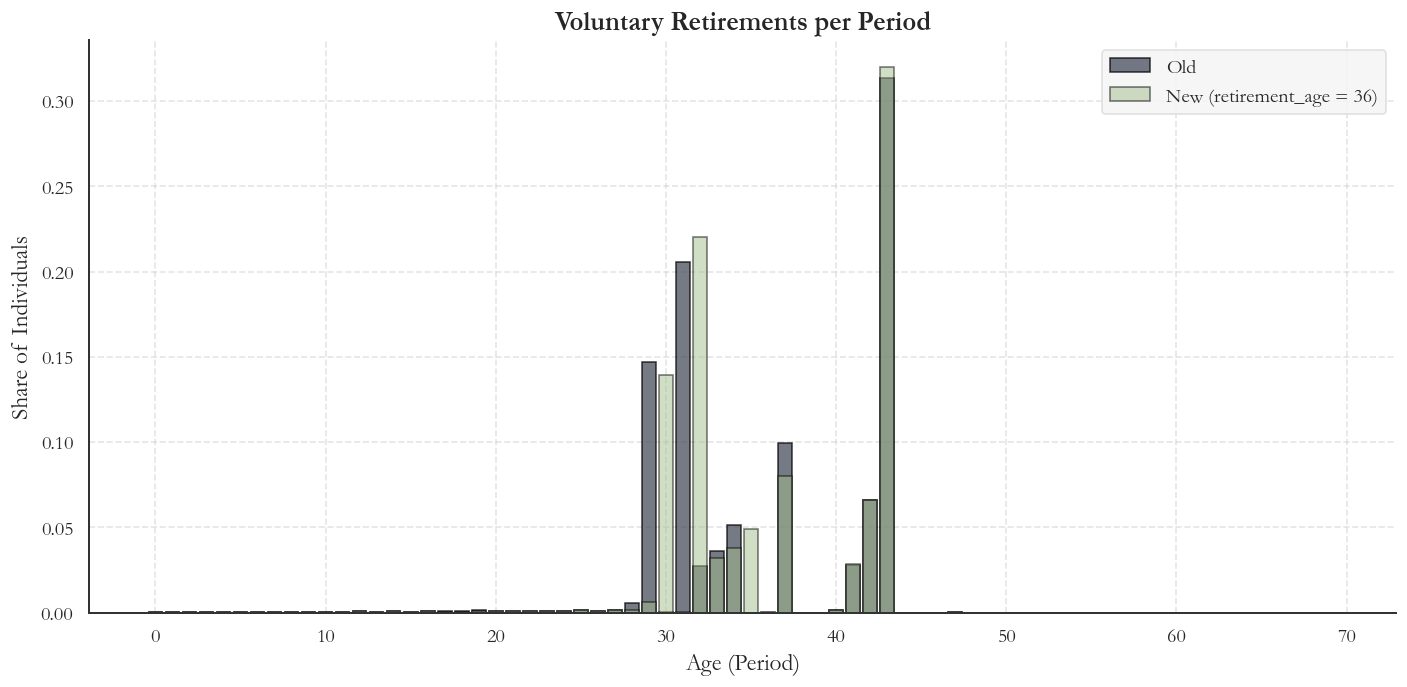

In [10]:
og_ret_counts = np.sum(og_model.sim.ret_flag[:, :], axis=0)
new_ret_counts = np.sum(new_model.sim.ret_flag[:, :], axis=0)
plot_bar_series_comparison(
    og_ret_counts,
    new_ret_counts,
    label1="Old",
    label2=f"New (retirement_age = {theta[0]})",
    title="Voluntary Retirements per Period",
    xlabel="Age (Period)",
    normalize=True,
    save_title="counterfactual_retirement_counts.png",
)


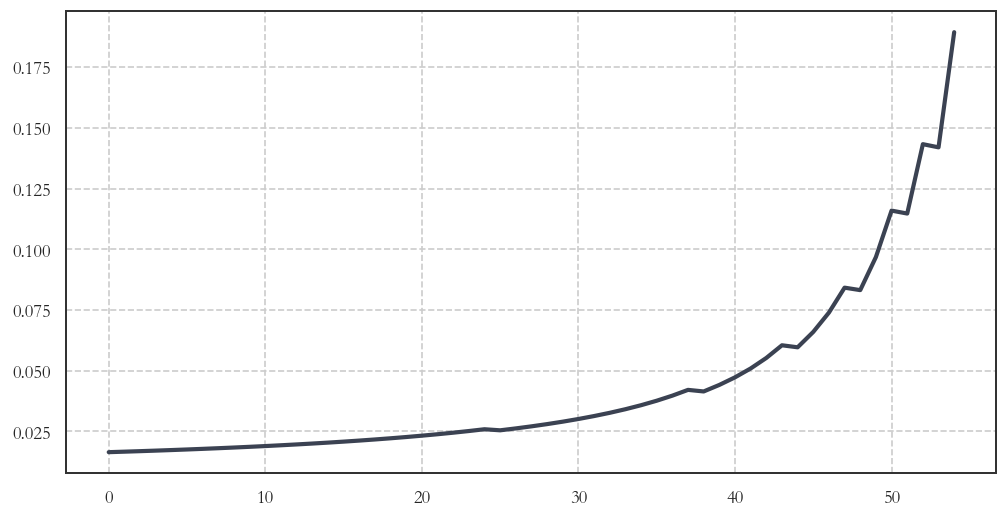

In [ ]:
test_list = []

for r in range(55):
    test_list.append((((1+par.r_s)**par.EL[int(r)])*par.share_lr)/np.sum((1+par.r_s)**(np.arange(par.EL[int(r)]))))
plt.plot(test_list)

In [ ]:
denom_list.append(np.sum((1+par.r_s)**(np.arange(par.EL[int(r)]))))


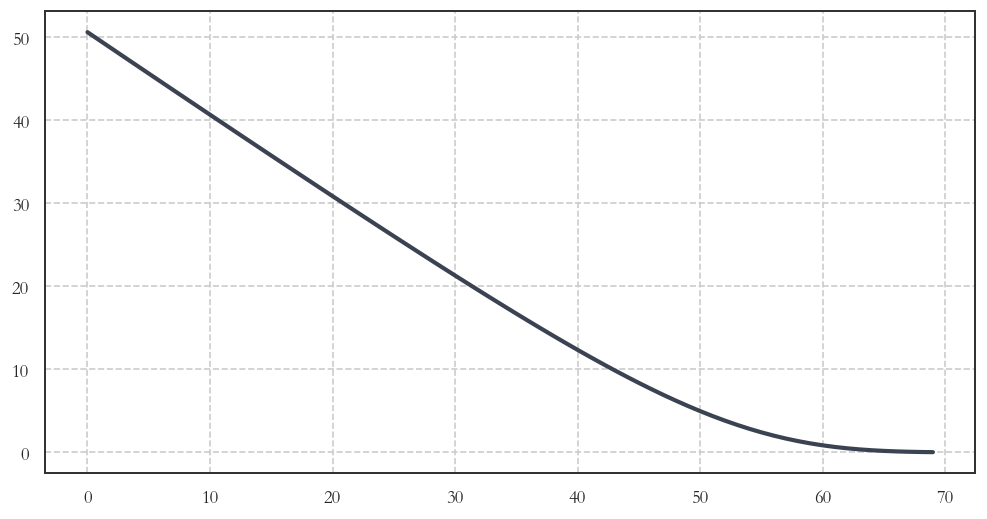

In [28]:
plt.plot(par.EL)

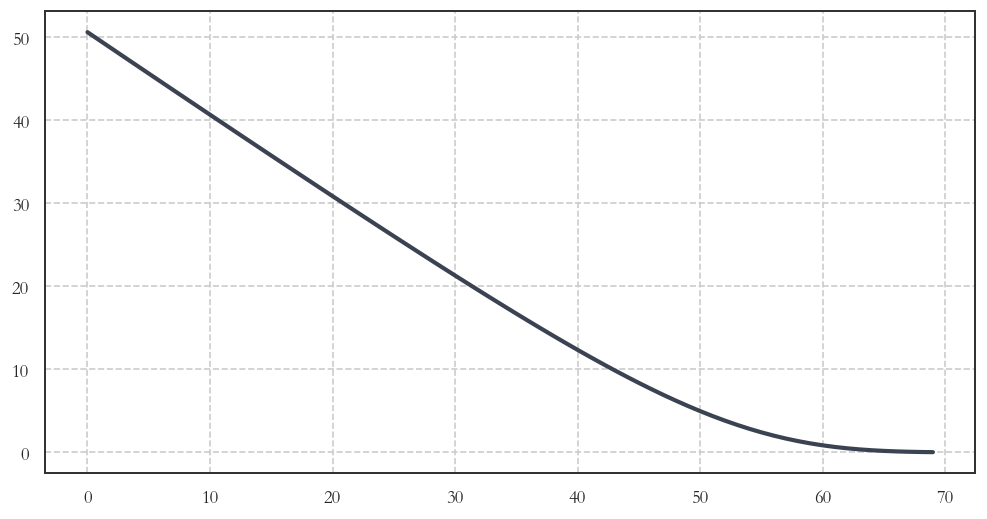

In [11]:
plt.plot(par.EL)

In [12]:
for i in range(len(og_model.sim.efter_init)):
    if og_model.sim.efter_init[i]:
        len(og_model.sim.ex[i,:]) - 1 - np.argmax(og_model.sim.ex[i,:][::-1] == 1)

In [13]:
og_model.sim.ex[i,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [14]:
len(og_model.sim.ex[i,:]) - 1 - np.argmax(og_model.sim.ex[i,:][::-1] == 1)

np.int64(30)

In [15]:
np.full(og_model.sim.e.shape[0], np.nan)

array([nan, nan, nan, ..., nan, nan, nan])

In [16]:
np.where(og_model.sim.e[i, :] == 2)[0]

array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69])

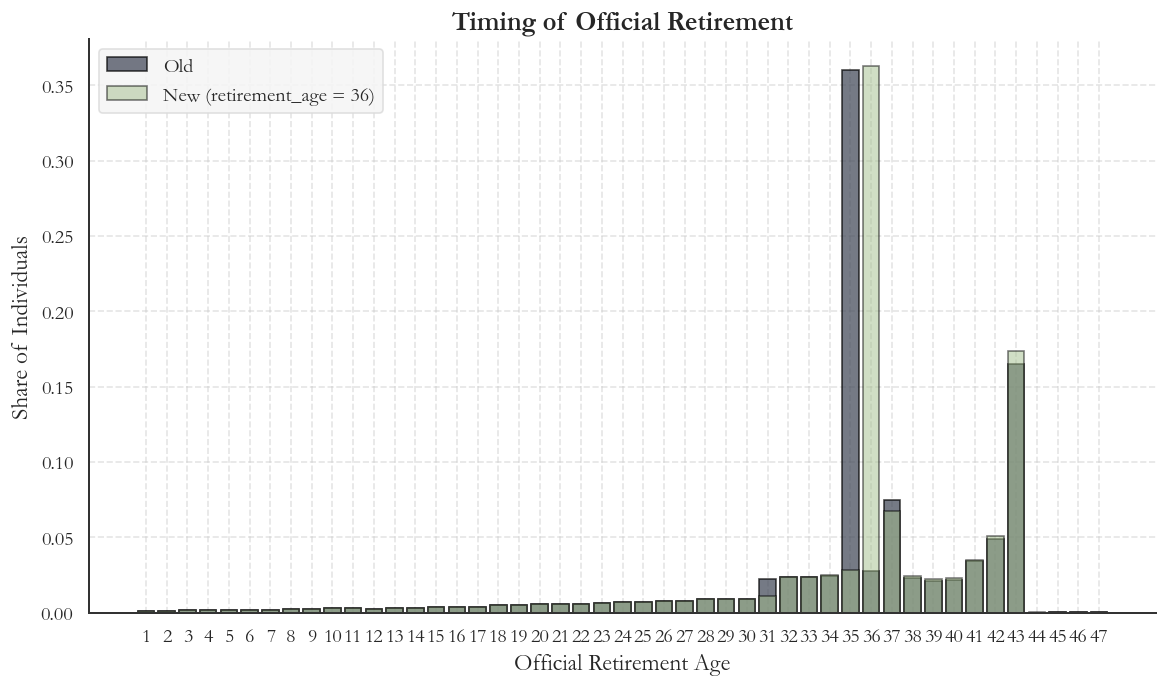

In [17]:
# 1. Find first time e == 2 for each individual
first_retirement = np.full(og_model.sim.e.shape[0], np.nan)  # initialize

for i in range(og_model.sim.e.shape[0]):
    retired = np.where(og_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired.size > 0:
        first_retirement[i] = retired[0]  # first time they retire

first_retirement_new = np.full(new_model.sim.e.shape[0], np.nan)  # initialize

for i in range(new_model.sim.e.shape[0]):
    retired_new = np.where(new_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired_new.size > 0:
        first_retirement_new[i] = retired_new[0]  # first time they retire
plot_event_bar_series(
    values1=first_retirement,
    values2=first_retirement_new,
    xlabel="Official Retirement Age",
    title="Timing of Official Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_official_retirement_age.png",
)


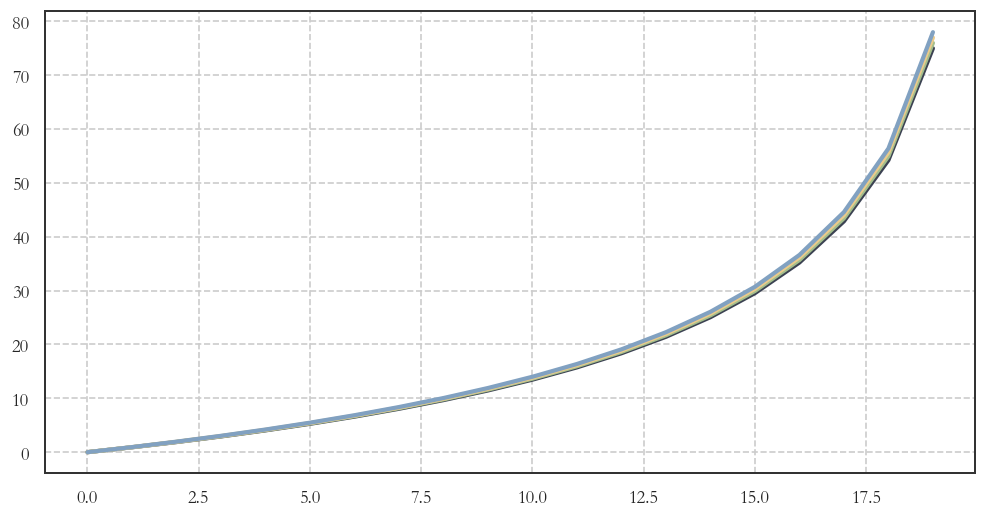

In [25]:
plt.plot(par.k_grid[35,:])
plt.plot(par.k_grid[36,:])
plt.plot(par.k_grid[37,:])
plt.plot(par.k_grid[38,:])

In [18]:
EV_age_indi_og = ev_model_indi(og_model)
EV_age_indi_new = ev_model_indi(new_model)

AttributeError: Rectangle.set() got an unexpected keyword argument 'median_val'

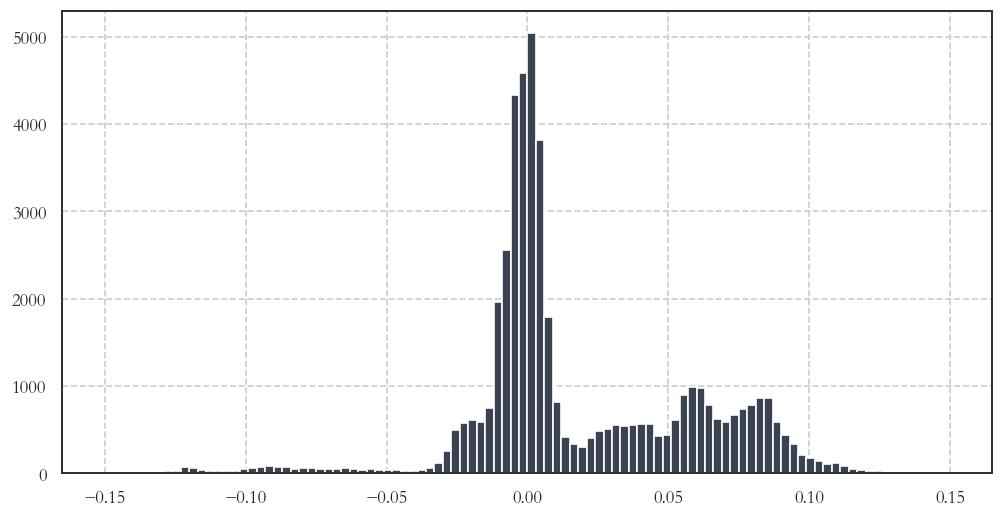

In [ ]:
an_age = 30
# plt.hist(np.array(EV_age_indi_new[an_age])- np.array(EV_age_indi_og[an_age]), bins=100, range=(-0.15,0.15), median_val=None, mean_val =None)
plt.axvline(np.median(np.array(EV_age_indi_new[an_age])- np.array(EV_age_indi_og[an_age])), label='Median', color='red')
plt.axvline(np.mean(np.array(EV_age_indi_new[an_age])- np.array(EV_age_indi_og[an_age])), label='Mean', color='blue')
plt.legend()

In [ ]:
EV_age_og, EV_weight_og = ev_model(og_model)

In [ ]:
EV_age_new, EV_weight_new = ev_model(new_model)

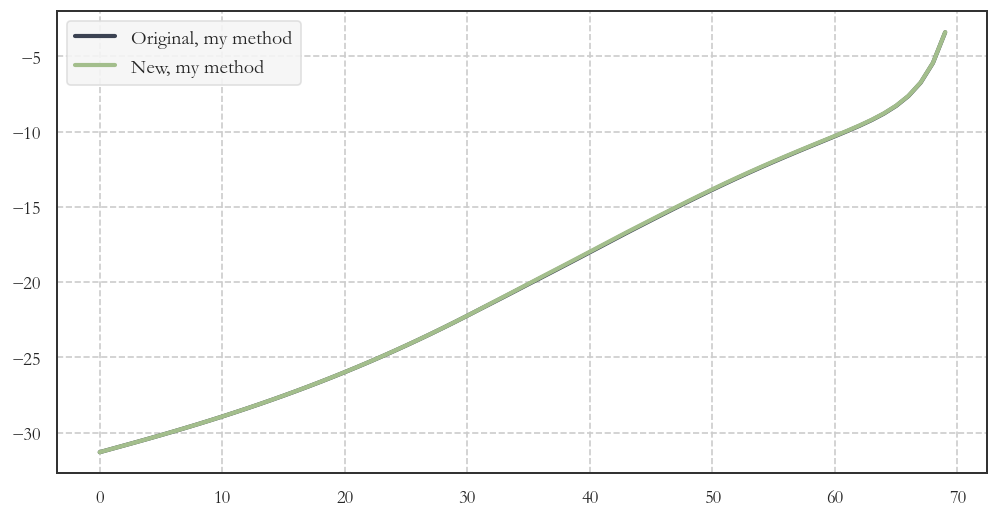

In [ ]:
plt.plot(EV_age_og, label='Original, my method')
plt.plot(EV_age_new, label='New, my method')
plt.legend()

In [ ]:
phi_age, phi_avg = analytical_age_phi(og_model, EV_age_new)

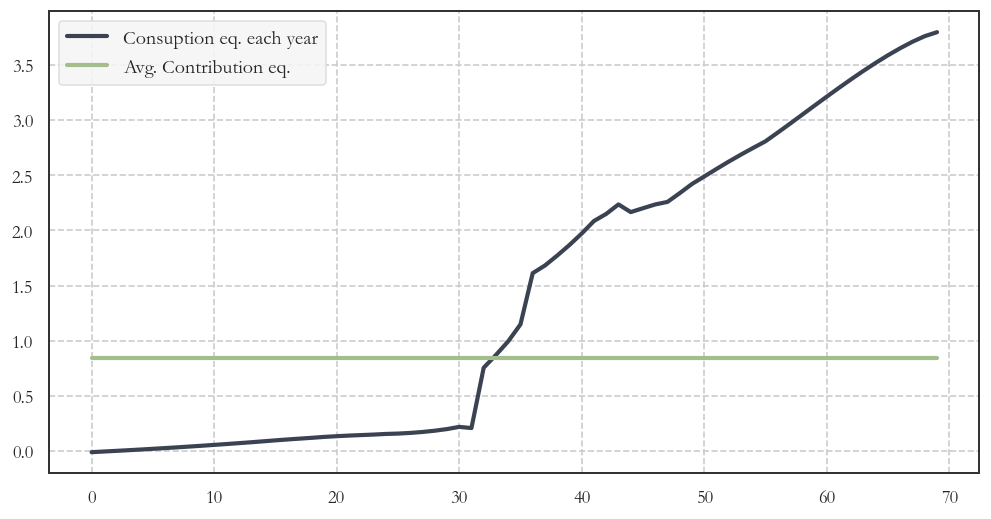

In [ ]:
plt.plot(phi_age*100, label='Consuption eq. each year')
sth =np.ones_like(phi_age)*phi_avg
plt.plot(sth*100, label='Avg. Contribution eq.')
plt.legend()

In [ ]:
EV_og_inter = EV_interpolering(og_model)

In [ ]:
EV_new_inter = EV_interpolering(new_model)

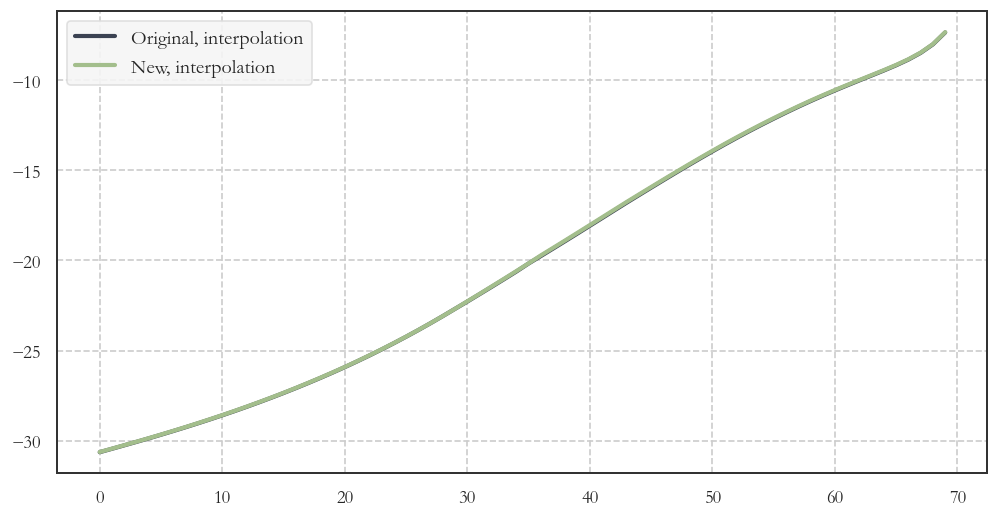

In [ ]:
plt.plot(EV_og_inter, label='Original, interpolation')
plt.plot(EV_new_inter, label='New, interpolation')
plt.legend()

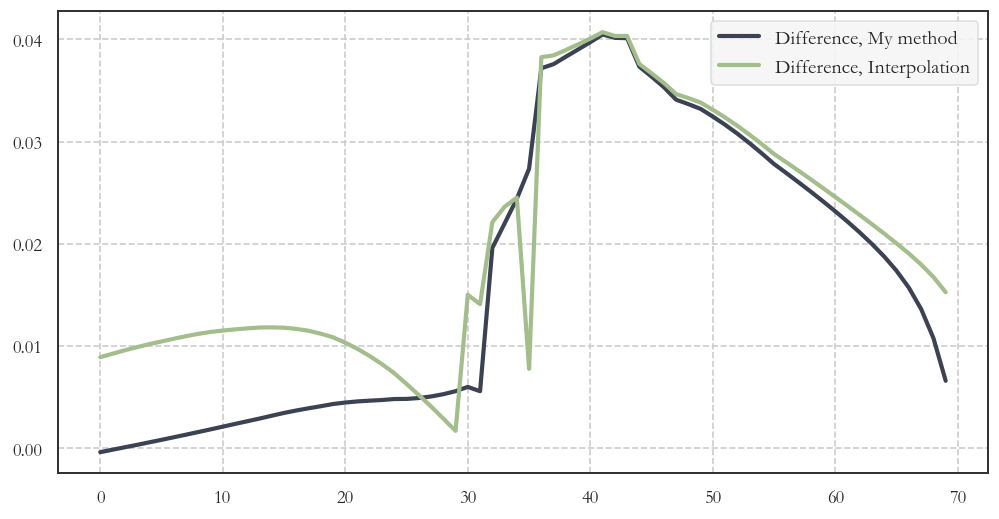

In [ ]:
plt.plot(np.array(EV_age_new)- np.array(EV_age_og), label='Difference, My method')
plt.plot(np.array(EV_new_inter)-np.array(EV_og_inter), label='Difference, Interpolation')
plt.legend()

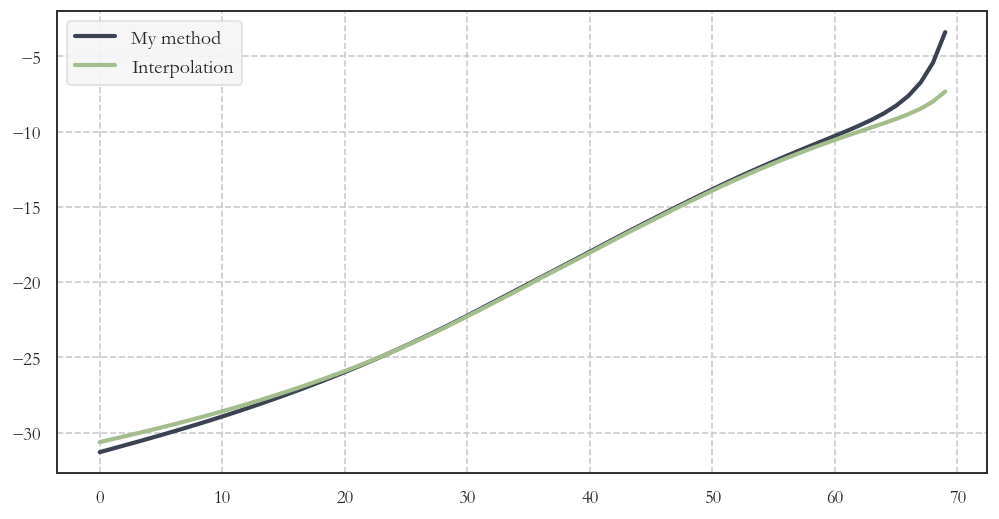

In [ ]:
plt.plot(np.array(EV_age_new), label='My method')
plt.plot(np.array(EV_new_inter), label='Interpolation')
plt.legend()

In [ ]:
model.sim.retirement_age

array([43., 28., 38., ..., 43., 37., 31.])

# comparison of means

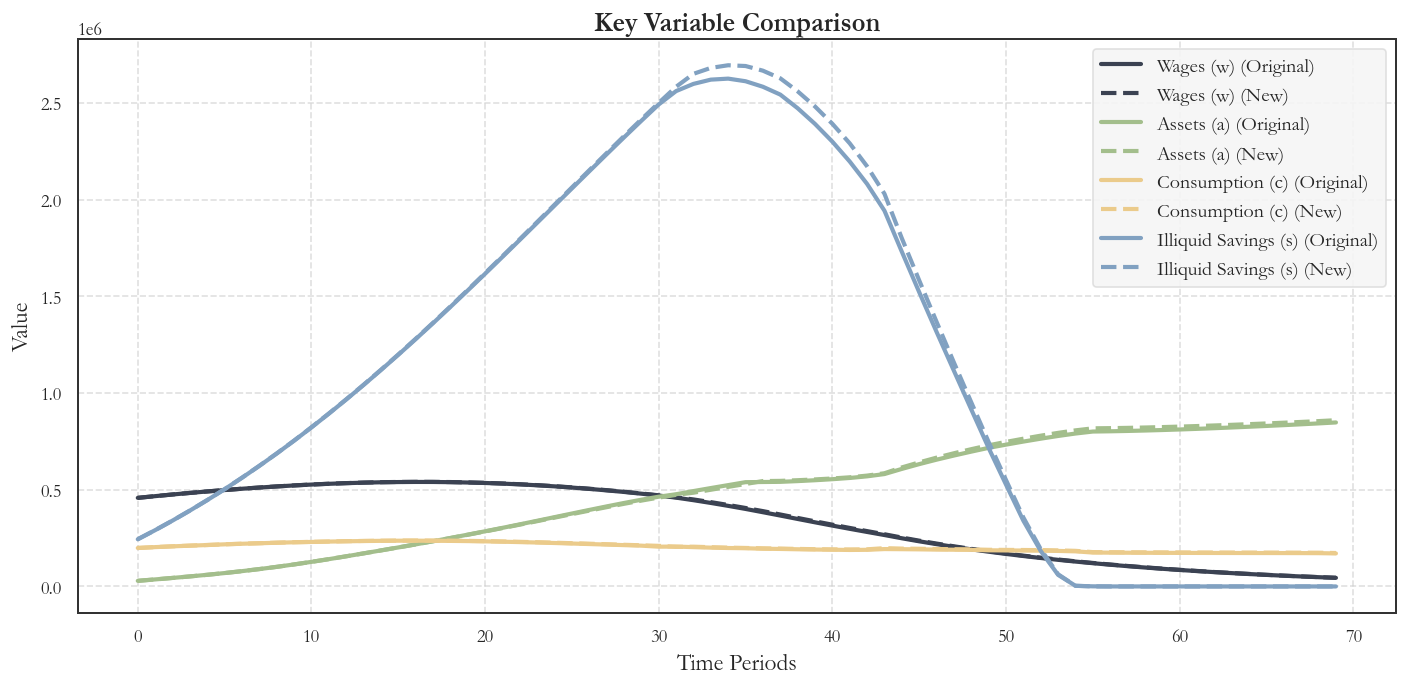

In [ ]:
time = np.arange(par.T)

# Data for selected summary variables
summary_vars = ["Wages (w)", "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"]
simulated_data_new = {
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
}
simulated_data_og = {
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
}

plot_comparison_single_panel(simulated_data_og, simulated_data_new, summary_vars, time, save_title="counterfactual_summary_vars.png")


C:\Users\B224264\AppData\Local\Temp\ipykernel_13584\65369719.py:5: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
C:\Users\B224264\AppData\Local\Temp\ipykernel_13584\65369719.py:17: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
C:\Users\B224264\AppData\Local\Temp\ipykernel_13584\65369719.py:29: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0)
C:\Users\B224264\AppData\Local\Temp\ipykernel_13584\65369719.py:30: RuntimeWarning: Mean of empty slice
  - np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),


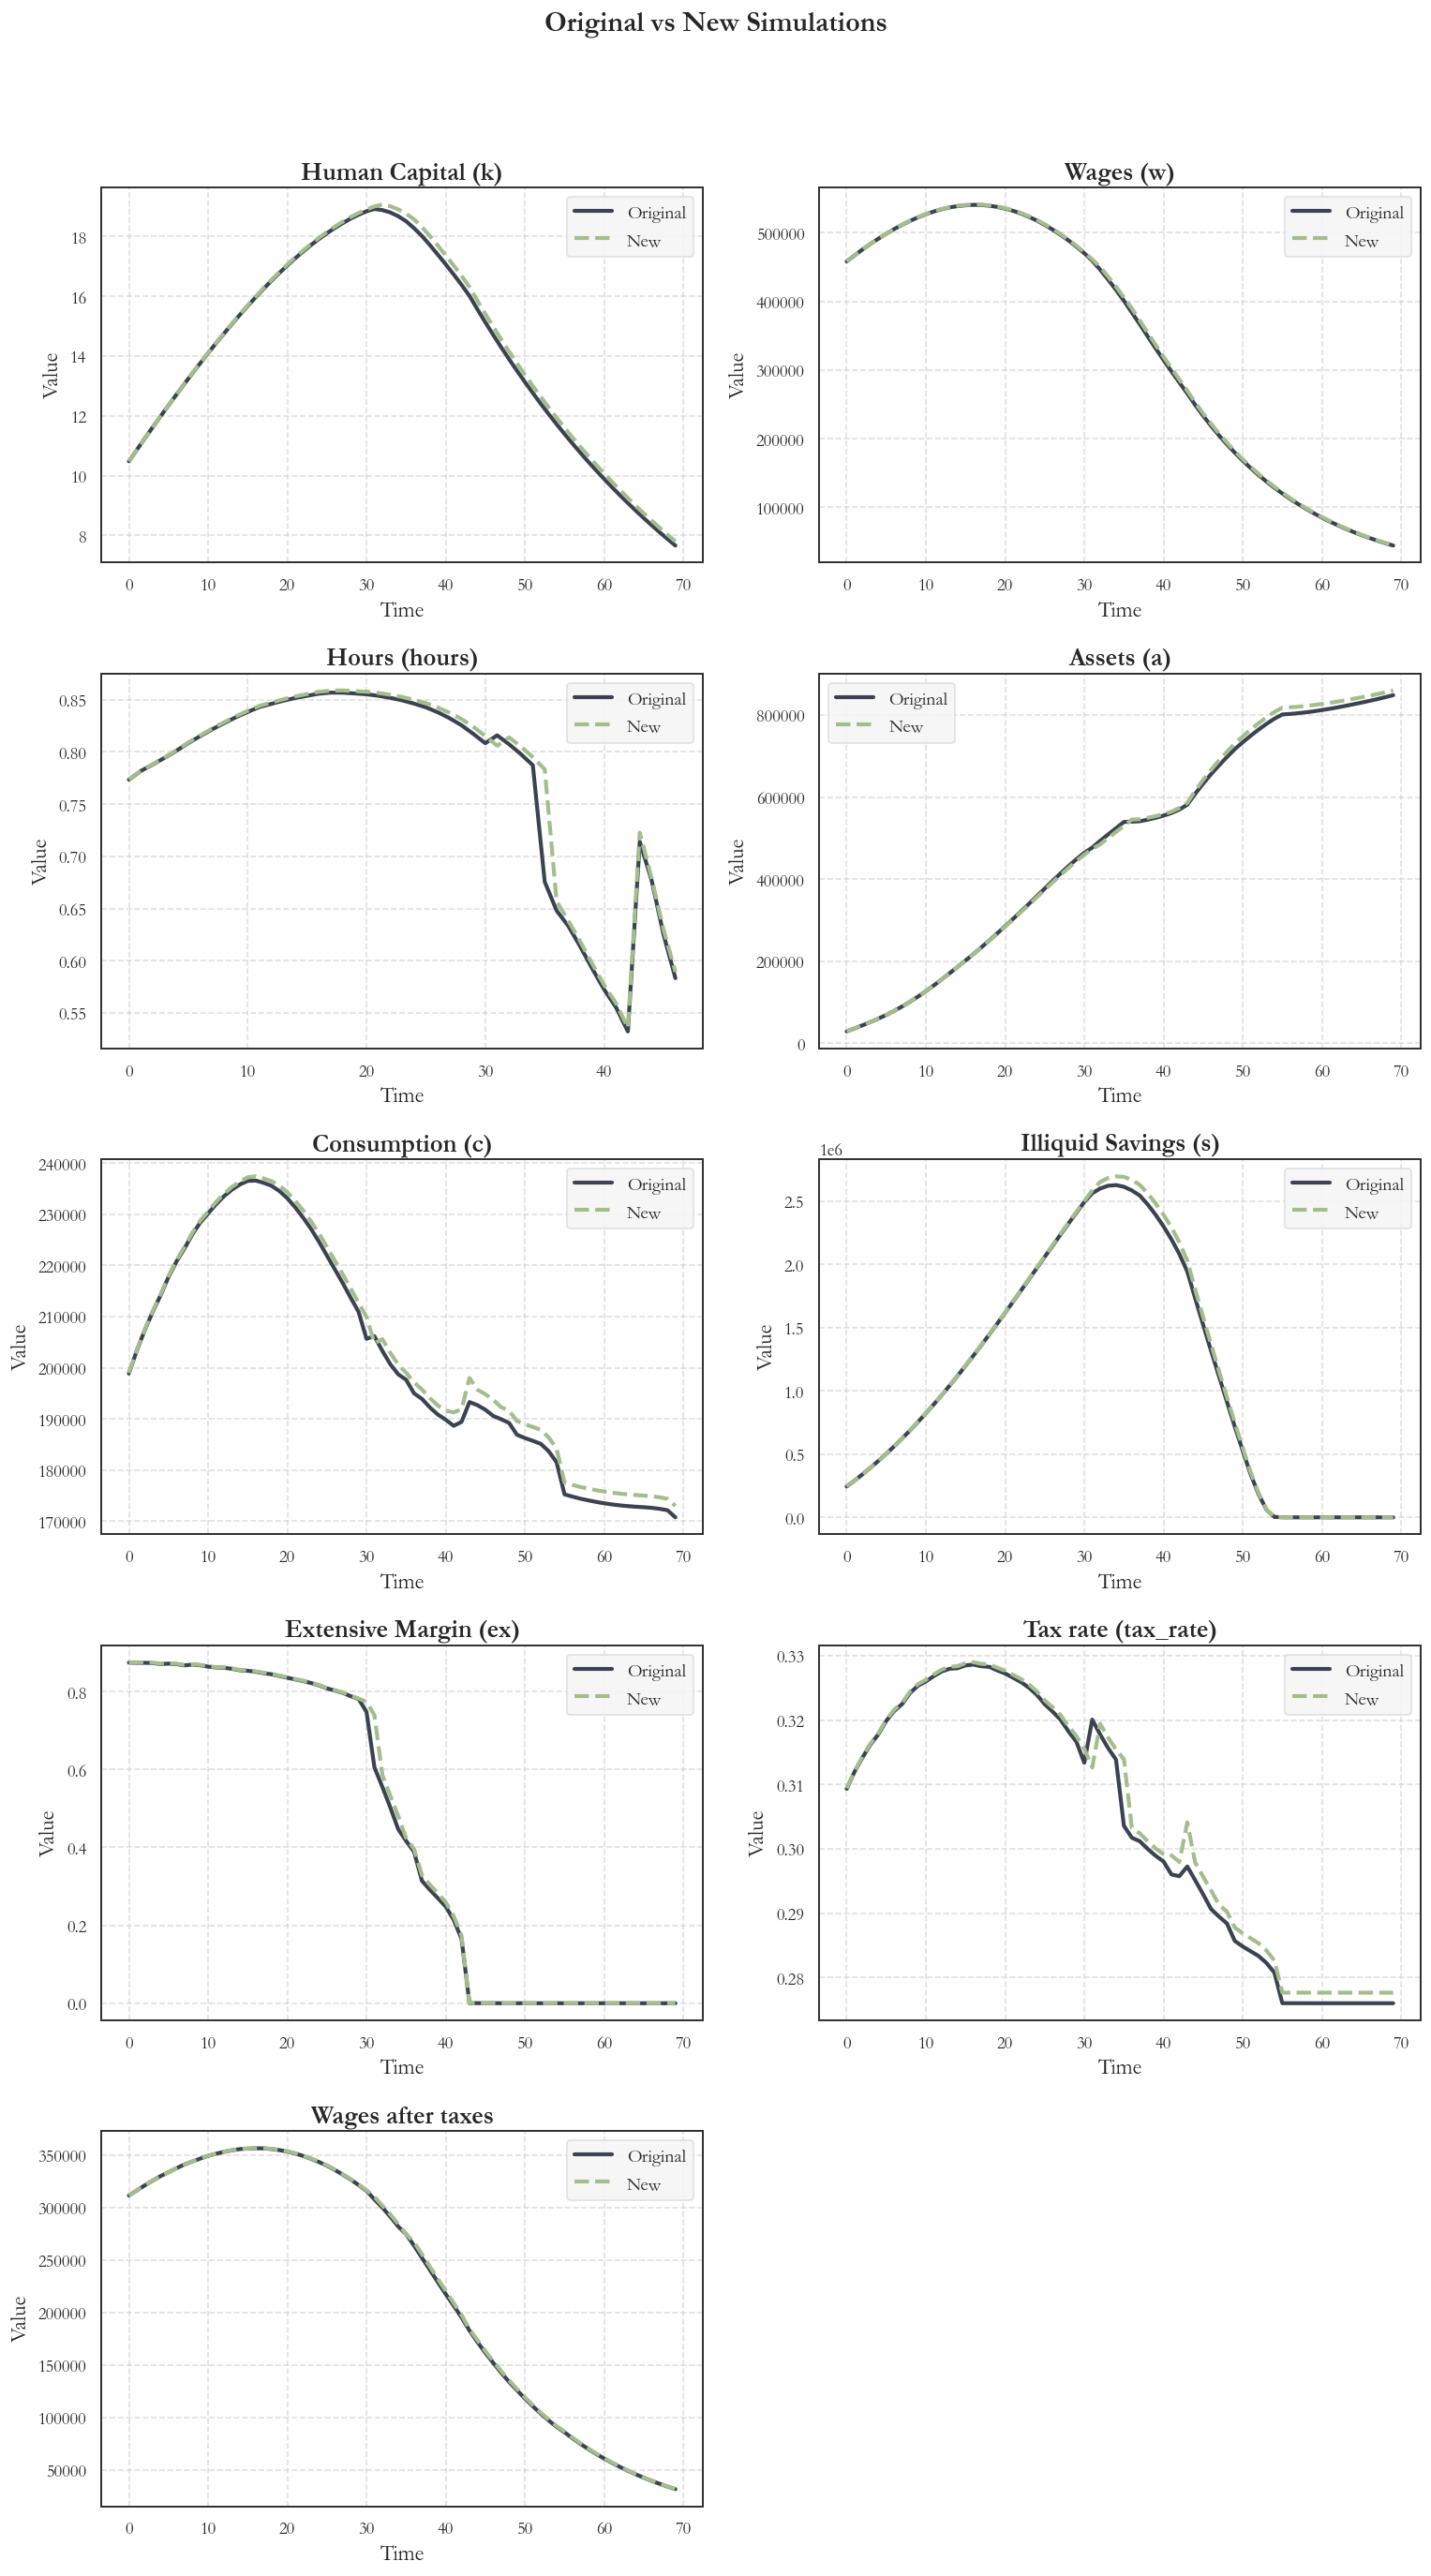

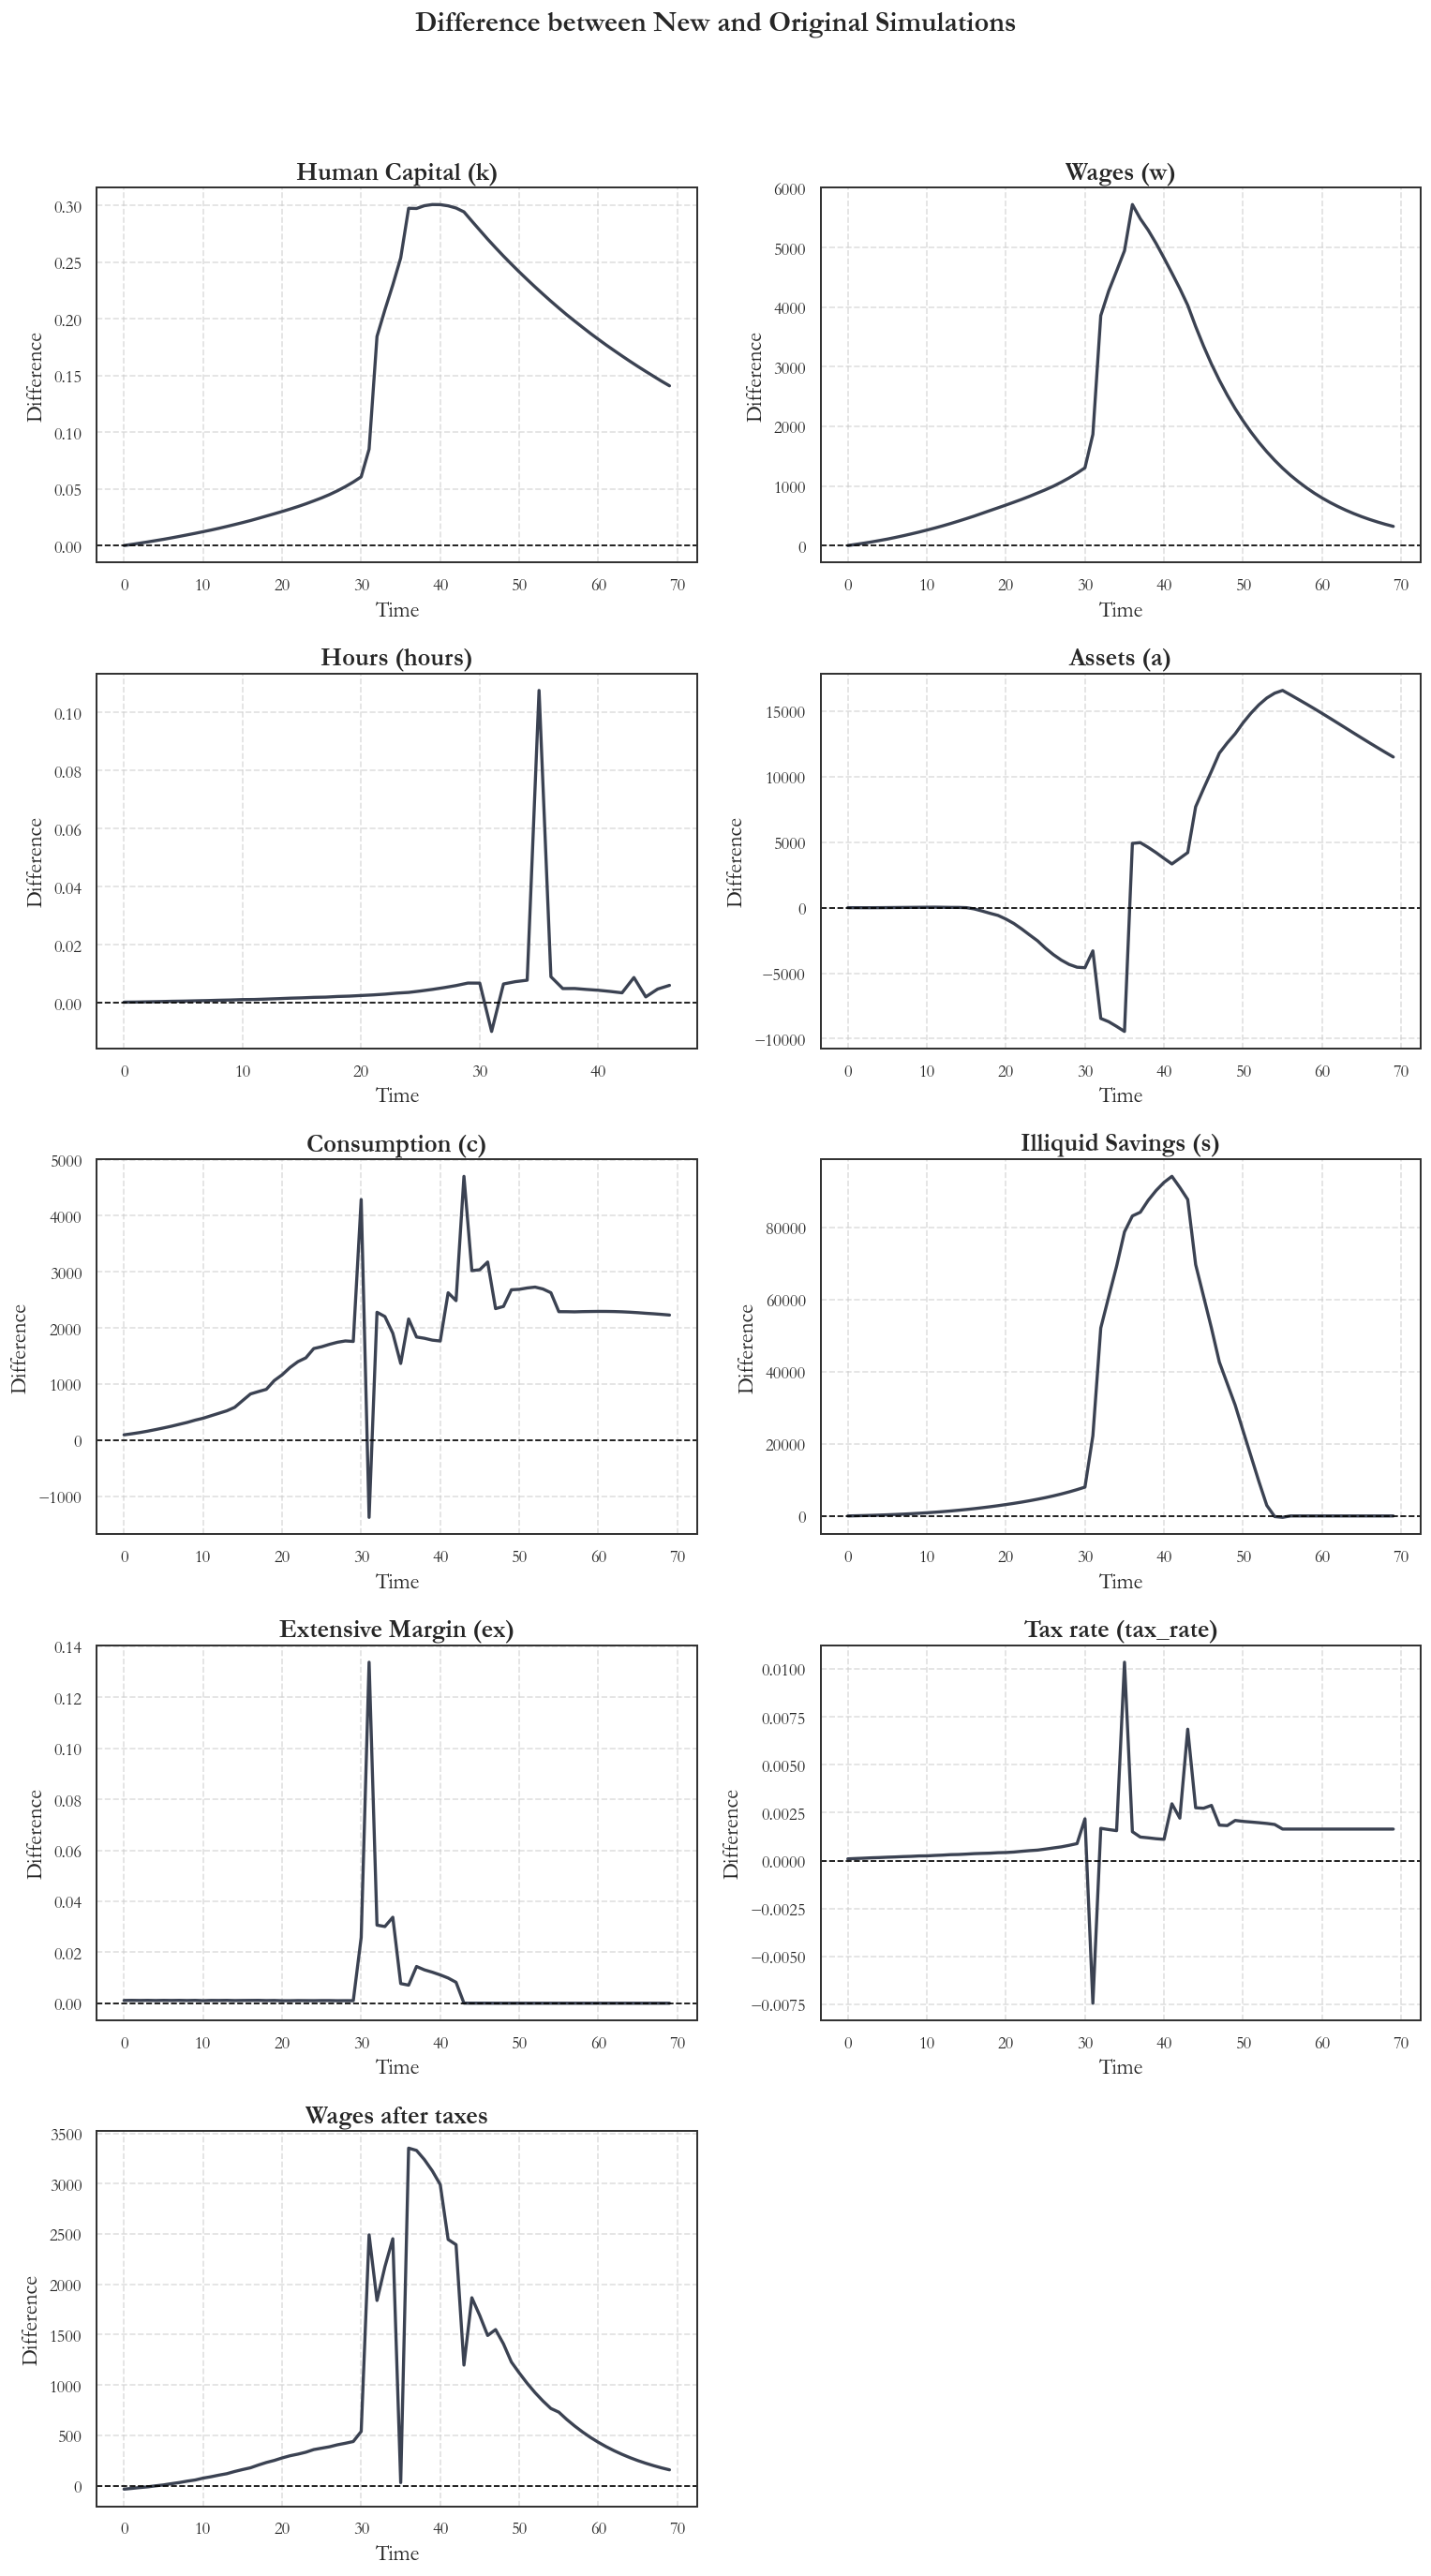

In [ ]:

# Full variable set
data_dict_new = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0),
}

data_dict_og = {
    "Human Capital (k)": np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0),
}

data_dict_diff = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0) - np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0) - np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0)
                    - np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0) - np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0) - np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0) - np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0) - np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0) - np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": (
        np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0)
        - np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0)
    ),
}

plot_comparison_grid(data_dict_og, data_dict_new, time, title="Original vs New Simulations", save_title="counterfactual_full_vars.png")
plot_difference_grid(data_dict_diff, time, title="Difference between New and Original Simulations", save_title="counterfactual_diff_full_vars.png")


In [ ]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(og_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(og_model.sim.ex.shape[0]):
    working = np.where(og_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1]  # last time they worked (take last index)

# 1. Find last time ex == 1 for each individual
last_working_new = np.full(new_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(new_model.sim.ex.shape[0]):
    working_new = np.where(new_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working_new.size > 0:
        last_working_new[i] = working_new[-1]  # last time they worked (take last index)
plot_event_bar_series(
    values1=last_working,
    values2=last_working_new,
    xlabel="Retirement Age",
    title="Timing of Unofficial Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_retirement_age.png",
)


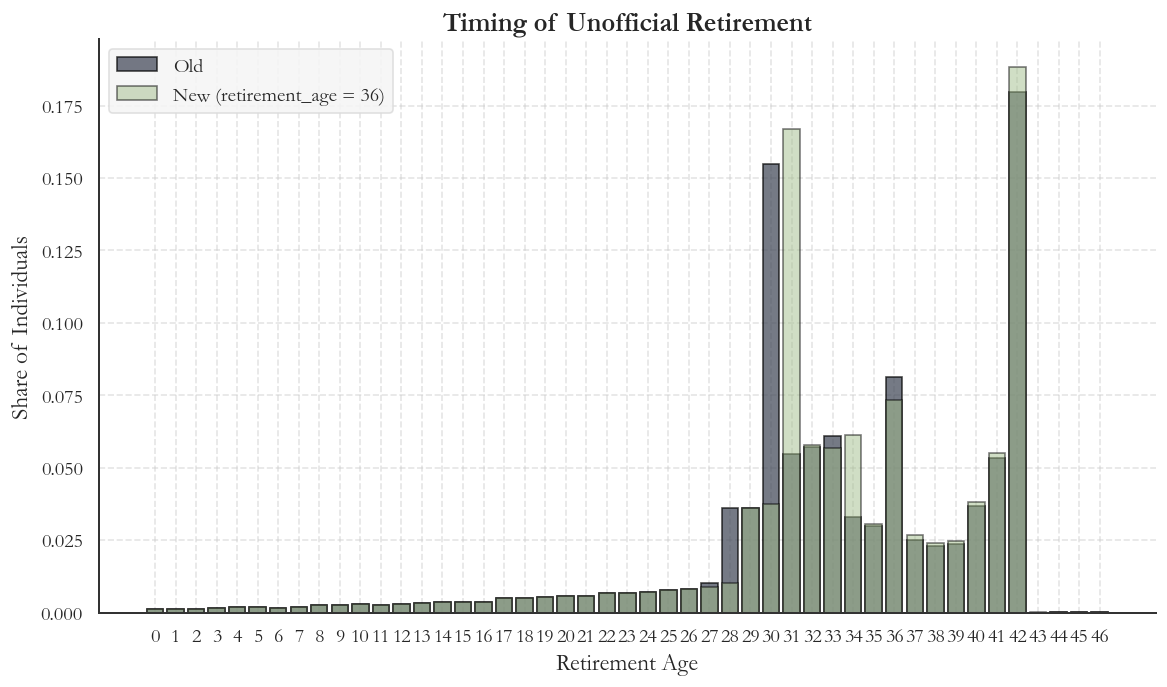

In [ ]:
plot_event_bar_series(
    values1=last_working,
    values2=last_working_new,
    xlabel="Retirement Age",
    title="Timing of Unofficial Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_retirement_age.png",
)


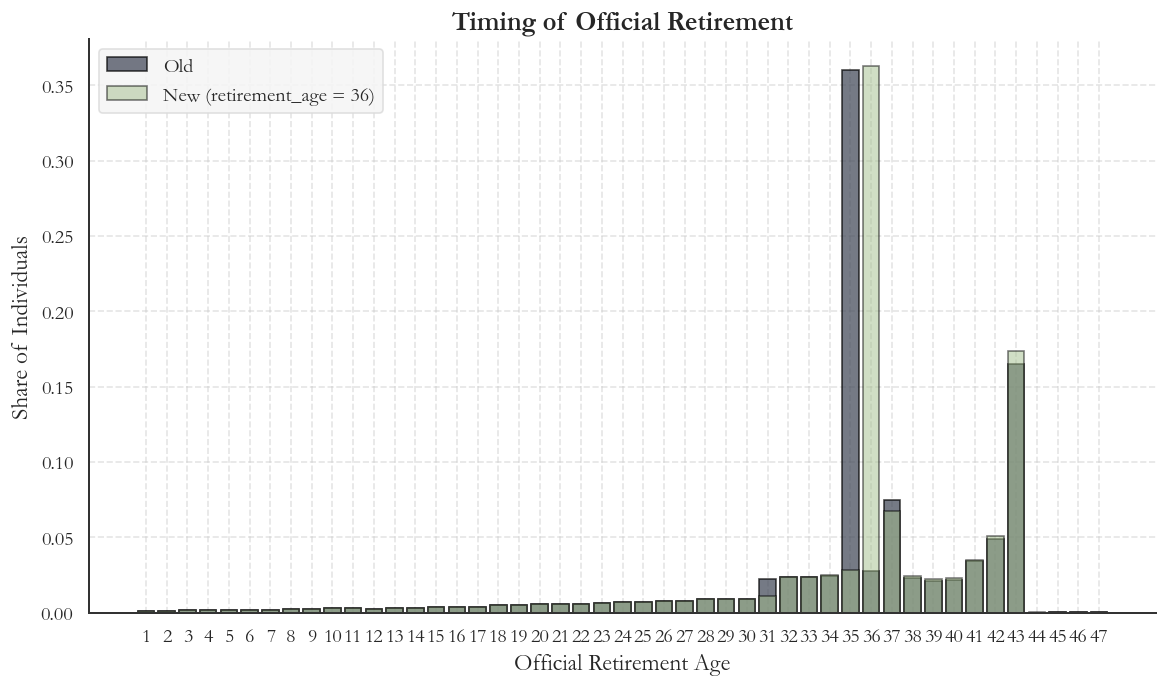

In [ ]:
# 1. Find first time e == 2 for each individual
first_retirement = np.full(og_model.sim.e.shape[0], np.nan)  # initialize

for i in range(og_model.sim.e.shape[0]):
    retired = np.where(og_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired.size > 0:
        first_retirement[i] = retired[0]  # first time they retire

first_retirement_new = np.full(new_model.sim.e.shape[0], np.nan)  # initialize

for i in range(new_model.sim.e.shape[0]):
    retired_new = np.where(new_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired_new.size > 0:
        first_retirement_new[i] = retired_new[0]  # first time they retire
plot_event_bar_series(
    values1=first_retirement,
    values2=first_retirement_new,
    xlabel="Official Retirement Age",
    title="Timing of Official Retirement",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    save_title="counterfactual_official_retirement_age.png",
)


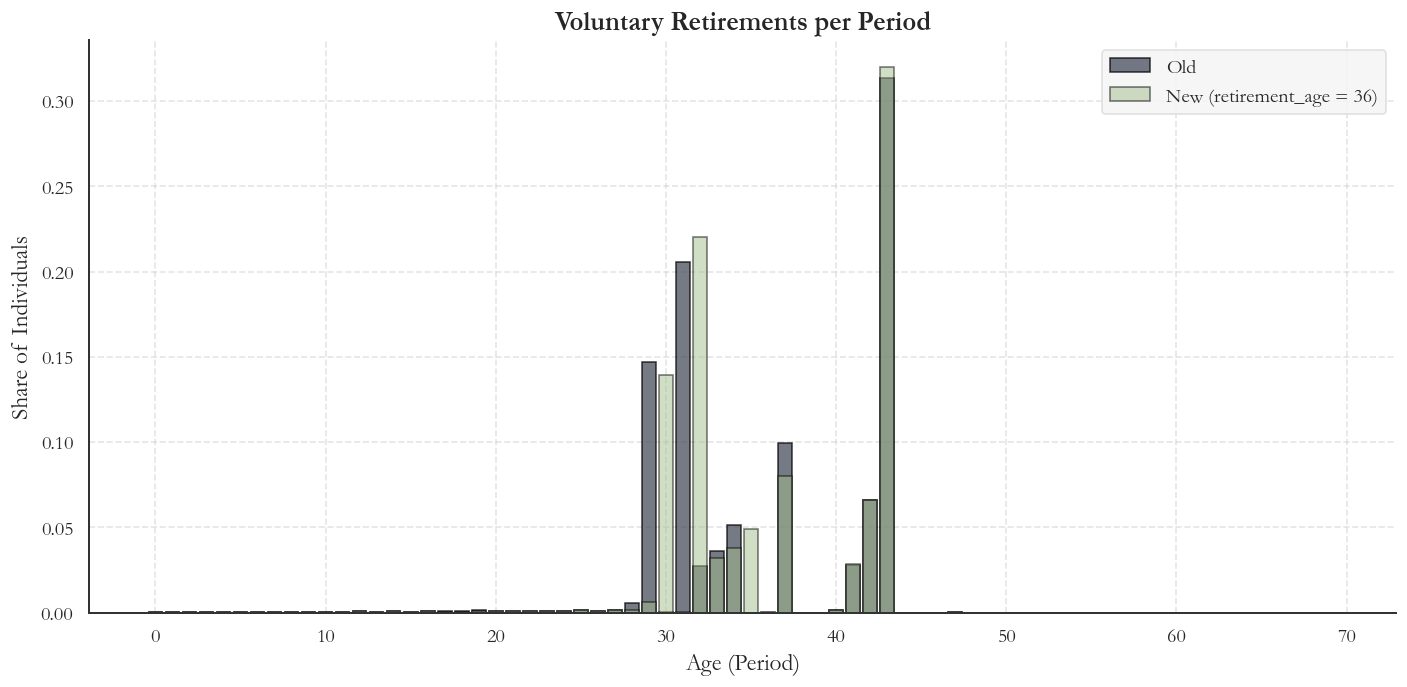

In [ ]:
og_ret_counts = np.sum(og_model.sim.ret_flag[:, :], axis=0)
new_ret_counts = np.sum(new_model.sim.ret_flag[:, :], axis=0)
plot_bar_series_comparison(
    og_ret_counts,
    new_ret_counts,
    label1="Old",
    label2=f"New (retirement_age = {theta[0]})",
    title="Voluntary Retirements per Period",
    xlabel="Age (Period)",
    normalize=True,
    save_title="counterfactual_retirement_counts.png",
)


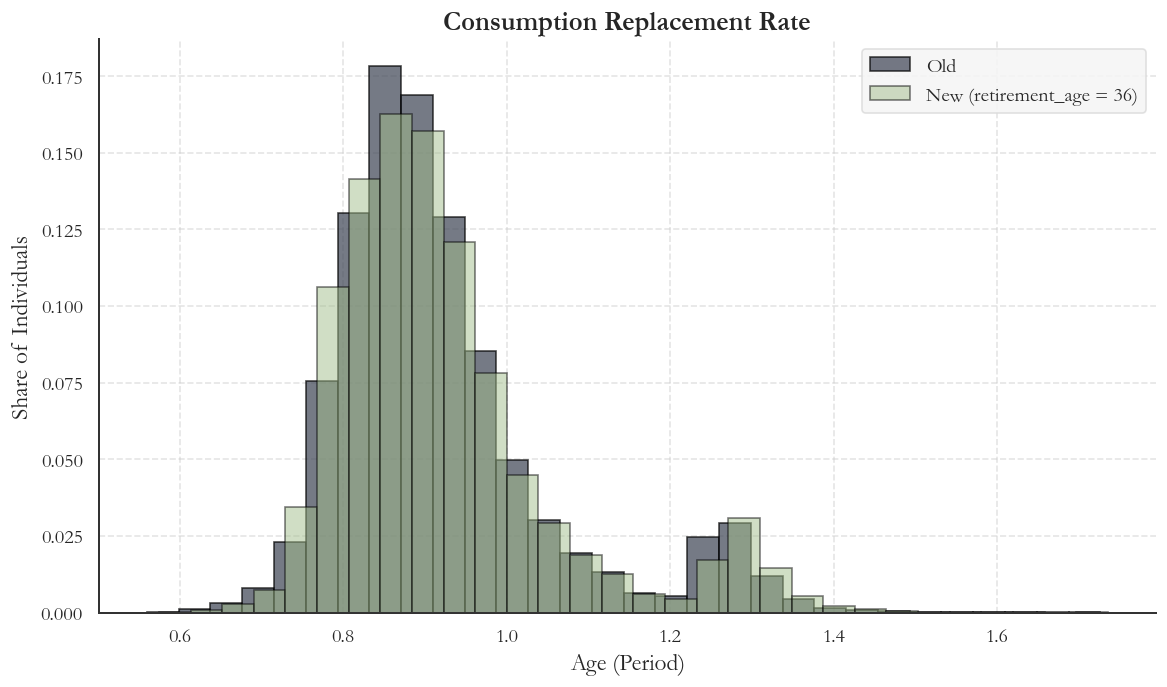

In [ ]:
plot_event_histogram(
    values1=consumption_replacement_rate_fct(og_model),
    values2=consumption_replacement_rate_fct(new_model),
    xlabel="Age (Period)",
    title="Consumption Replacement Rate",
    label1="Old",
    label2=f'New ({theta_names[0]} = {theta[0]})',
    bins=30,
    save_title="counterfactual_consumption_replacement_histogram.png",
)

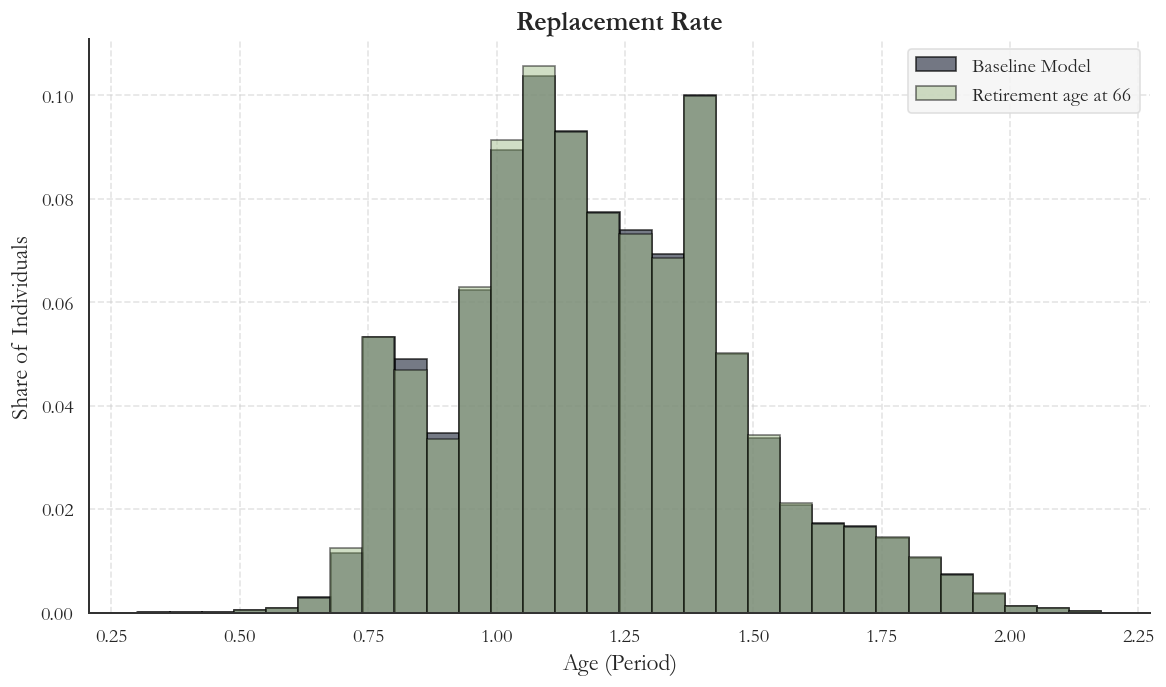

In [ ]:
plot_event_histogram(
    values1=replacement_rate_fct(og_model),
    values2=replacement_rate_fct(new_model),
    xlabel="Age (Period)",
    title="Replacement Rate",
    label1="Baseline Model",
    label2="Retirement age at 66",
    bins=30,
    save_title="replacement_rate_66_ret_age.png"
)


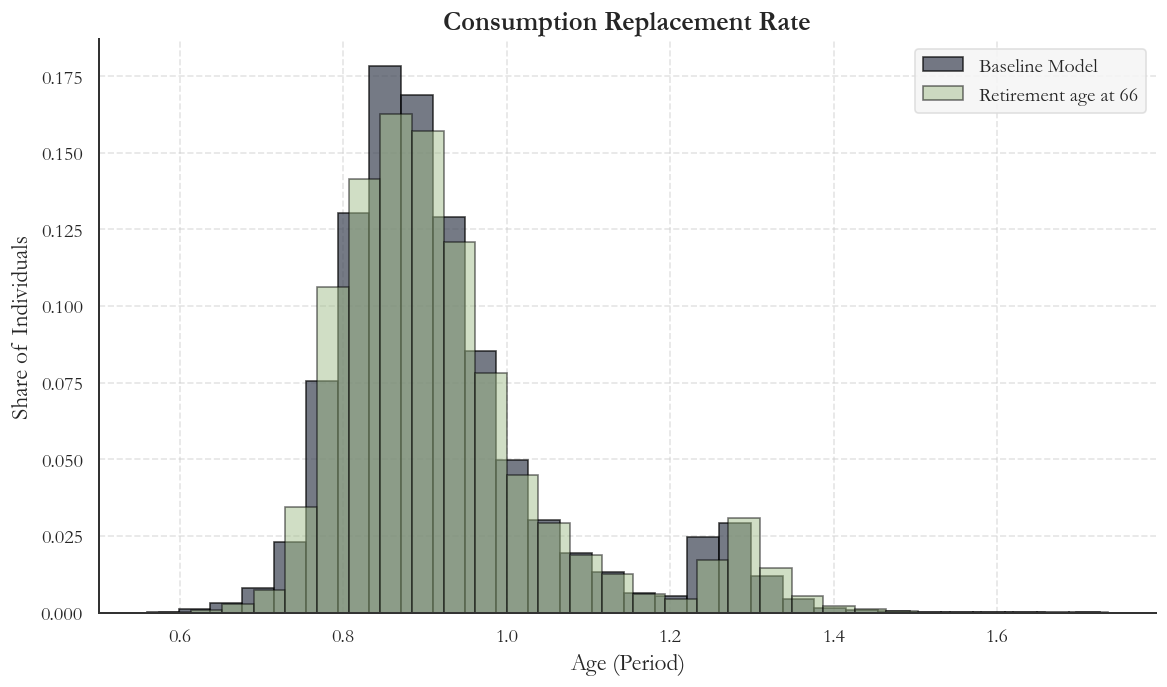

In [ ]:
plot_event_histogram(
    values1=consumption_replacement_rate_fct(og_model),
    values2=consumption_replacement_rate_fct(new_model),
    xlabel="Age (Period)",
    title="Consumption Replacement Rate",
    label1="Baseline Model",
    label2="Retirement age at 66",
    bins=30,
    save_title="consumption_replacement_rate_66_ret_age.png"
)


# Comparison of retirement age

# replacement rates

In [ ]:
assert False

AssertionError: 

# Optimal retirement payments according to welfare

In [ ]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([1.35e+01, 8.00e-02, 5.00e-04])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

# Optimal retirement payments according to welfare conditioning on pension being the same

In [ ]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    if np.mean(og_model.sim.s[:, 35]) > np.mean(new_model.sim.s[:, 35]):
        consumption_eq = -9999.9

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([ 2.0, 0.4,  0.001])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

In [ ]:
# constant, beta1, beta2 = np.array([ 1.46922503e+01, -2.31206543e-02,  6.27520107e-04]) # Current optimal giving 0.0065521344388923845 consumption eq.
constant, beta1, beta2 = np.array([ 1.48536631e+01, -4.18610966e-02,  6.47243901e-04]) # Test start


time = np.arange(par.T)

tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

plt.plot(tau)
plt.plot(par.tau)
plt.show()


In [ ]:
theta = [tau]
theta_names = ['tau']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

In [ ]:
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# set up 2x2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (key, (sim, emp)) in zip(axes, a_dict.items()):
    x_vals = np.arange(len(emp)) + par.start_age

    # real data: solid grey
    ax.plot(x_vals, emp,
            color='grey',
            linestyle='-',
            linewidth=2,
            label=f"Real {key.capitalize()}")

    # simulated data: darker dashed
    ax.plot(x_vals, sim,
            color='black',
            linestyle='--',
            linewidth=2,
            label=f"Simulated {key.capitalize()}")

    ax.set_xlabel("Age")
    ax.set_ylabel(key.capitalize())
    ax.set_title(key.capitalize())
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()
